# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random

# Import Data

## Sales

In [2]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` order by sku, site_id, year, week desc'
sales_df = utils.bq_to_dataframe(query, verbose=True).pipe(utils.reduce_memory_usage)

c:\dev\verteiler\venv\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


********************
Query Duration:  0:01:57.571581
Mem. usage decreased to 208.94 Mb (42.2% reduction)


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5921278 entries, 0 to 5921277
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Week         int8   
 1   Year         int16  
 2   Site_ID      int16  
 3   SKU          int32  
 4   Sales_QTY    float32
 5   Season_Year  object 
 6   Vendor_ID    object 
 7   Vendor_Name  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(3)
memory usage: 208.9+ MB


## Stock

In [4]:
query = "SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_stock_weekly` order by SKU, site_id, year, week desc"
stock_df = utils.bq_to_dataframe(query, verbose=True).pipe(utils.reduce_memory_usage)


********************
Query Duration:  0:00:30.059903
Mem. usage decreased to 21.18 Mb (52.5% reduction)


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169099 entries, 0 to 1169098
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Week     1169099 non-null  int8   
 1   Year     1169099 non-null  int16  
 2   Site_ID  1169099 non-null  object 
 3   SKU      1169099 non-null  int32  
 4   Stock    1169099 non-null  float32
dtypes: float32(1), int16(1), int32(1), int8(1), object(1)
memory usage: 21.2+ MB


In [6]:
stock_df.sort_values(by=['SKU', 'Site_ID','Year','Week'])

,Week,Year,Site_ID,SKU,Stock
50,2,2018,g116,3082255,144.0
49,3,2018,g116,3082255,144.0
48,4,2018,g116,3082255,144.0
47,5,2018,g116,3082255,143.0
46,6,2018,g116,3082255,143.0
...,...,...,...,...,...
1169091,51,2020,g116,1289250704,2.0
1169097,48,2020,g101,1289250705,2.0
1169096,49,2020,g101,1289250705,2.0
1169095,50,2020,g101,1289250705,2.0


# Merge Sales and Stock Data

In [7]:
# Adjust data types for merge
sales_df['Site_ID'] = 'g' + sales_df.Site_ID.astype(str)

In [8]:
df = sales_df.merge(stock_df, how='left', on=['SKU', 'Week', 'Year', 'Site_ID'])
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
...,...,...,...,...,...,...,...,...,...
5921273,51,2020,g102,1289250704,1.0,9999,0000948574,Santoni S.P.A.,2.0
5921274,50,2020,g116,1289250704,2.0,9999,0000948574,Santoni S.P.A.,2.0
5921275,49,2020,g101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,2.0
5921276,48,2020,g101,1289250705,0.0,9999,0000948574,Santoni S.P.A.,2.0


# SKU, Vendor, Season_Year - Data Exploration

In [9]:
df.SKU.drop_duplicates().count()

10825

In [10]:
df[['SKU', 'Season_Year', 'Vendor_Name']].drop_duplicates().Season_Year.value_counts()

2020    6360
9999    4261
2019     157
2018      23
2021      15
2017       8
2016       1
Name: Season_Year, dtype: int64

In [11]:
print('Number of vendors: ', df.Vendor_Name.drop_duplicates().count())
print('\nSummary:\n ',df[['SKU', 'Season_Year', 'Vendor_Name']].drop_duplicates().Vendor_Name.value_counts().head(25))

Number of vendors:  160

Summary:
  Tommy Hilfiger Europe BV         1426
RALPH LAUREN GERMANY GMBH        1172
BRAX                              726
Strellson AG                      418
Diesel S.p.A.                     403
Eton AB                           392
Calvin Klein Europe BV            374
Fashion Box Switzerland AG        360
Zimmerli Textil AG                286
Corinus AG Fashion Group          253
Hanro AG                          228
Isa Seta SPA                      221
FOSTER SPA                        215
Fibretex SPA                      205
Tiger of Sweden                   165
J. Weder-Meier AG                 156
Swiss Hest GmbH                   154
Paul Smith Ltd                    147
KMC Garment                       139
Allsaints Wholesale Ltd.          133
Bollag-Guggenheim AG              125
RAGMAN TEXTILHANDEL GMBH          122
Dagsmejan Ventures AG             118
Confezioni Damap SRL              107
PAN-KO PANTALON KONF. TEKSTIL      93
Name: Vendor_N

# Sales - Data Exploration

In [12]:
# Overall
print('Mean: ', df.Sales_QTY.mean())
print('Std.: ', df.Sales_QTY.std())
print('\nDeciles:\n', df.Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.22697279
Std.:  1.0006729

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     1.0
1.0    68.0
Name: Sales_QTY, dtype: float64


In [13]:
# Basic-Articles
print('Mean: ', df.loc[df.Season_Year == '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year == '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year == '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.21865295
Std.:  1.0065318

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     1.0
1.0    68.0
Name: Sales_QTY, dtype: float64


In [14]:
# Seasonal Articles
print('Mean: ', df.loc[df.Season_Year != '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year != '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year != '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.41327897
Std.:  0.83770335

Deciles:
 0.0    -7.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     1.0
0.8     1.0
0.9     1.0
1.0    52.0
Name: Sales_QTY, dtype: float64


In [15]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
...,...,...,...,...,...,...,...,...,...
5921273,51,2020,g102,1289250704,1.0,9999,0000948574,Santoni S.P.A.,2.0
5921274,50,2020,g116,1289250704,2.0,9999,0000948574,Santoni S.P.A.,2.0
5921275,49,2020,g101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,2.0
5921276,48,2020,g101,1289250705,0.0,9999,0000948574,Santoni S.P.A.,2.0


In [16]:
df['Year_Week'] = df.Year.astype(str) + df.Week.astype(str)
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
5921273,51,2020,g102,1289250704,1.0,9999,0000948574,Santoni S.P.A.,2.0,202051
5921274,50,2020,g116,1289250704,2.0,9999,0000948574,Santoni S.P.A.,2.0,202050
5921275,49,2020,g101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,2.0,202049
5921276,48,2020,g101,1289250705,0.0,9999,0000948574,Santoni S.P.A.,2.0,202048


# Plot Time-Series

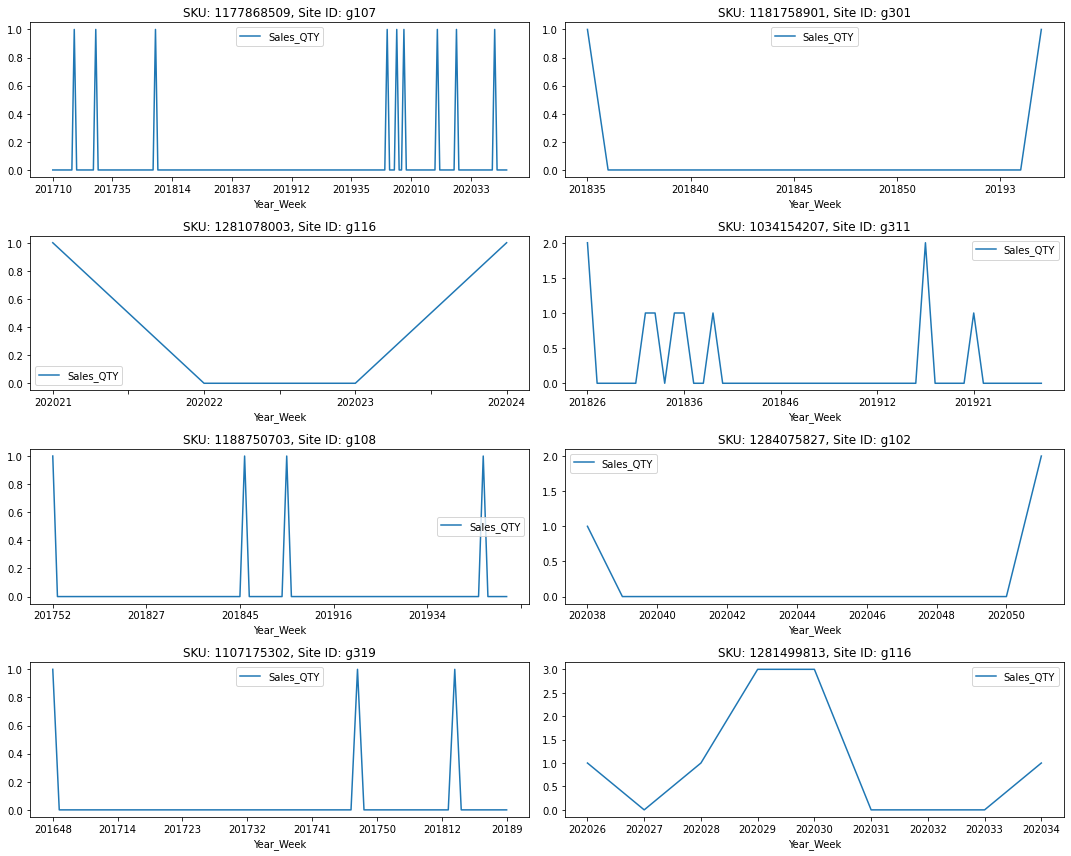

In [17]:
n_series = 8

# Sample n random occurences
samples = df[['SKU', 'Site_ID']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for article, site in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])
    ax_idx += 1
    
plt.tight_layout()
plt.show()

# Plot Time Series for Top-Sellers

In [18]:
# Get SKU / Store combinations with a mean sale greater a threshold
top_sellers_mean = df[['Site_ID', 'SKU', 'Sales_QTY']].groupby(['Site_ID', 'SKU']).mean() 
top_sellers_mean = top_sellers_mean.loc[top_sellers_mean.Sales_QTY > 0.2]
top_sellers_mean

Sales_QTY
Site_ID SKU                  
g101    2069466      0.202925
        2069474      1.010563
        2069482      1.015734
        2069490      0.285441
        2069505      0.417832
...                       ...
g590    1288677901   1.000000
        1288694506   0.428571
        1288695801   3.000000
        1288695802   0.500000
        1288695803   1.000000

[59305 rows x 1 columns]

In [19]:
# Get SKU / Store combinations which timeseries is longer than a threshold
top_sellers_length = df[['Site_ID', 'SKU', 'Sales_QTY']].loc[df.Sales_QTY > 0].groupby(['Site_ID', 'SKU']).count()
top_sellers_length = top_sellers_length.loc[top_sellers_length.Sales_QTY > 8]
top_sellers_length

Sales_QTY
Site_ID SKU                  
g101    2069466            55
        2069474           205
        2069482           158
        2069490            62
        2069505            99
...                       ...
g590    1284239302          9
        1284240902         12
        1284242002         11
        1284243902         13
        1284244402         11

[15818 rows x 1 columns]

In [20]:
# select only SKUs that meet both requirements 
top_sellers = top_sellers_mean.merge(top_sellers_length, how='inner', on=['Site_ID', 'SKU'])
top_sellers = top_sellers.reset_index(drop=False)[['Site_ID', 'SKU']]
top_sellers

,Site_ID,SKU
0,g101,2069466
1,g101,2069474
2,g101,2069482
3,g101,2069490
4,g101,2069505
...,...,...
4092,g590,1284239302
4093,g590,1284240902
4094,g590,1284242002
4095,g590,1284243902


In [21]:
# Print number of articles that are top sellers (it at least one store)
len(top_sellers.SKU.drop_duplicates())

988

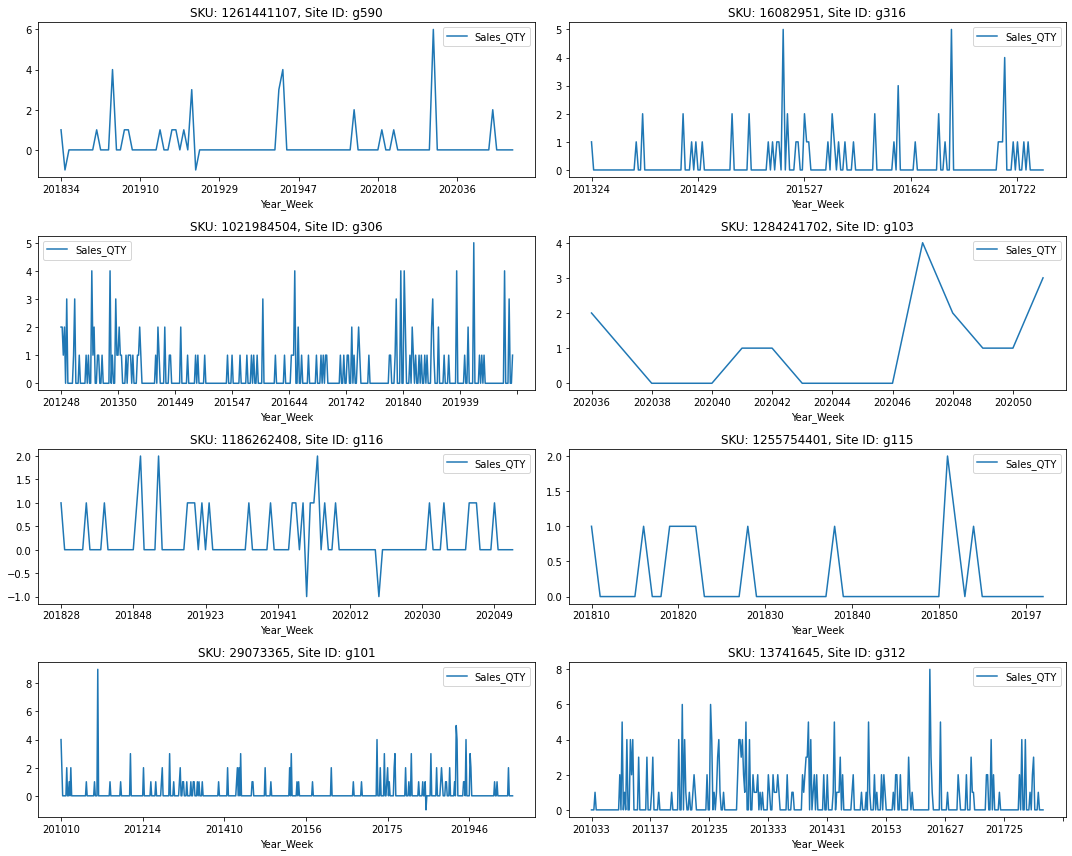

In [22]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()


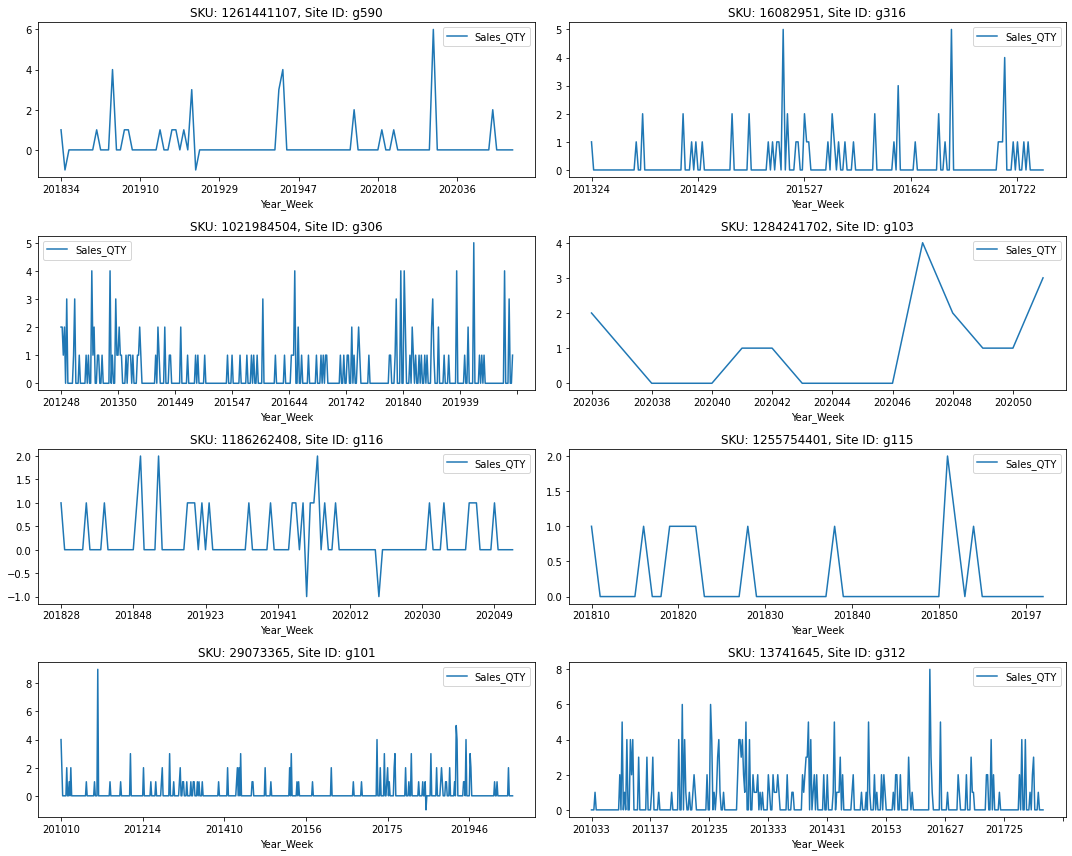

In [23]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()


In [24]:
# Basic-Articles
print('Mean: ', df.loc[df.Season_Year == '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year == '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year == '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.21865295
Std.:  1.0065318

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     1.0
1.0    68.0
Name: Sales_QTY, dtype: float64


In [25]:
# Seasonal Articles
print('Mean: ', df.loc[df.Season_Year != '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year != '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year != '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.41327897
Std.:  0.83770335

Deciles:
 0.0    -7.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     1.0
0.8     1.0
0.9     1.0
1.0    52.0
Name: Sales_QTY, dtype: float64


In [26]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
5921273,51,2020,g102,1289250704,1.0,9999,0000948574,Santoni S.P.A.,2.0,202051
5921274,50,2020,g116,1289250704,2.0,9999,0000948574,Santoni S.P.A.,2.0,202050
5921275,49,2020,g101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,2.0,202049
5921276,48,2020,g101,1289250705,0.0,9999,0000948574,Santoni S.P.A.,2.0,202048


In [27]:
df['Year_Week'] = df.Year.astype(str) + df.Week.astype(str)
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
5921273,51,2020,g102,1289250704,1.0,9999,0000948574,Santoni S.P.A.,2.0,202051
5921274,50,2020,g116,1289250704,2.0,9999,0000948574,Santoni S.P.A.,2.0,202050
5921275,49,2020,g101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,2.0,202049
5921276,48,2020,g101,1289250705,0.0,9999,0000948574,Santoni S.P.A.,2.0,202048


# Plot Time-Series

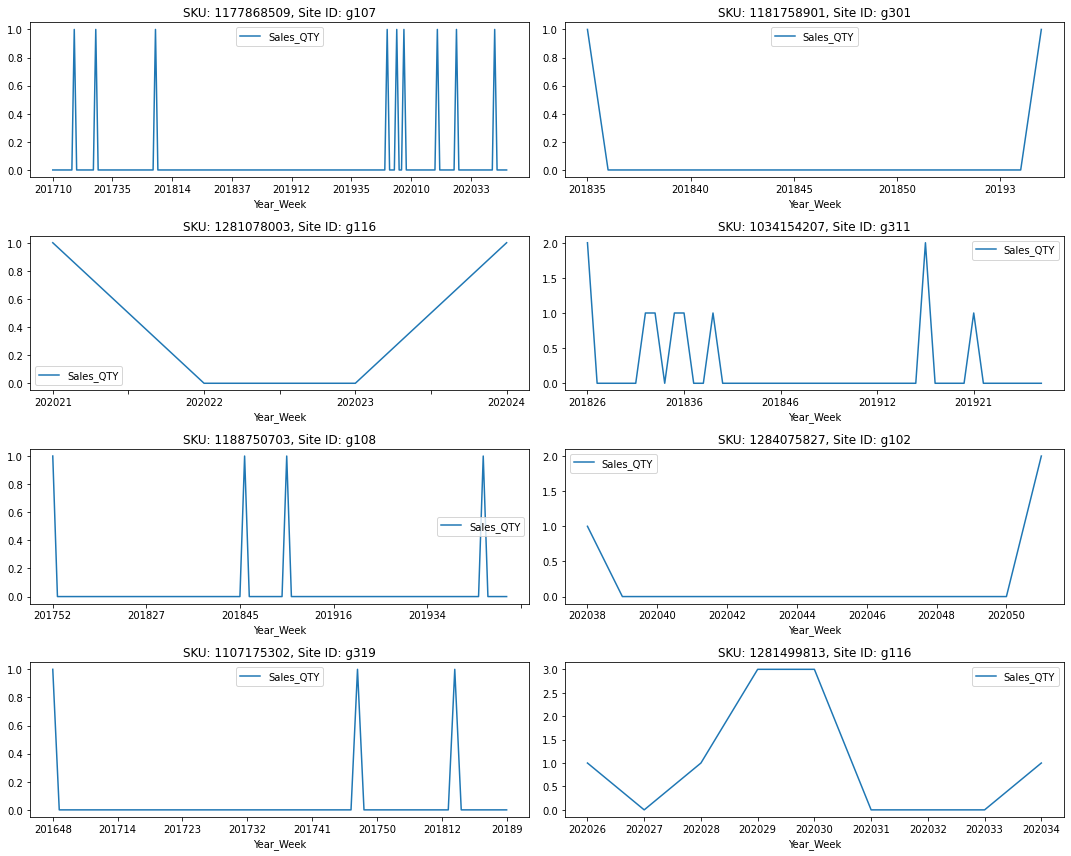

In [28]:
n_series = 8

# Sample n random occurences
samples = df[['SKU', 'Site_ID']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for article, site in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])
    ax_idx += 1
    
plt.tight_layout()
plt.show()

# Plot Time Series for Top-Sellers

In [29]:
# Get SKU / Store combinations with a mean sale greater a threshold
top_sellers_mean = df[['Site_ID', 'SKU', 'Sales_QTY']].groupby(['Site_ID', 'SKU']).mean() 
top_sellers_mean = top_sellers_mean.loc[top_sellers_mean.Sales_QTY > 0.2]
top_sellers_mean

Sales_QTY
Site_ID SKU                  
g101    2069466      0.202925
        2069474      1.010563
        2069482      1.015734
        2069490      0.285441
        2069505      0.417832
...                       ...
g590    1288677901   1.000000
        1288694506   0.428571
        1288695801   3.000000
        1288695802   0.500000
        1288695803   1.000000

[59305 rows x 1 columns]

In [30]:
# Get SKU / Store combinations which timeseries is longer than a threshold
top_sellers_length = df[['Site_ID', 'SKU', 'Sales_QTY']].loc[df.Sales_QTY > 0].groupby(['Site_ID', 'SKU']).count()
top_sellers_length = top_sellers_length.loc[top_sellers_length.Sales_QTY > 8]
top_sellers_length

Sales_QTY
Site_ID SKU                  
g101    2069466            55
        2069474           205
        2069482           158
        2069490            62
        2069505            99
...                       ...
g590    1284239302          9
        1284240902         12
        1284242002         11
        1284243902         13
        1284244402         11

[15818 rows x 1 columns]

In [31]:
# select only SKUs that meet both requirements 
top_sellers = top_sellers_mean.merge(top_sellers_length, how='inner', on=['Site_ID', 'SKU'])
top_sellers = top_sellers.reset_index(drop=False)[['Site_ID', 'SKU']]
top_sellers

,Site_ID,SKU
0,g101,2069466
1,g101,2069474
2,g101,2069482
3,g101,2069490
4,g101,2069505
...,...,...
4092,g590,1284239302
4093,g590,1284240902
4094,g590,1284242002
4095,g590,1284243902


In [32]:
# Print number of articles that are top sellers (it at least one store)
len(top_sellers.SKU.drop_duplicates())

988

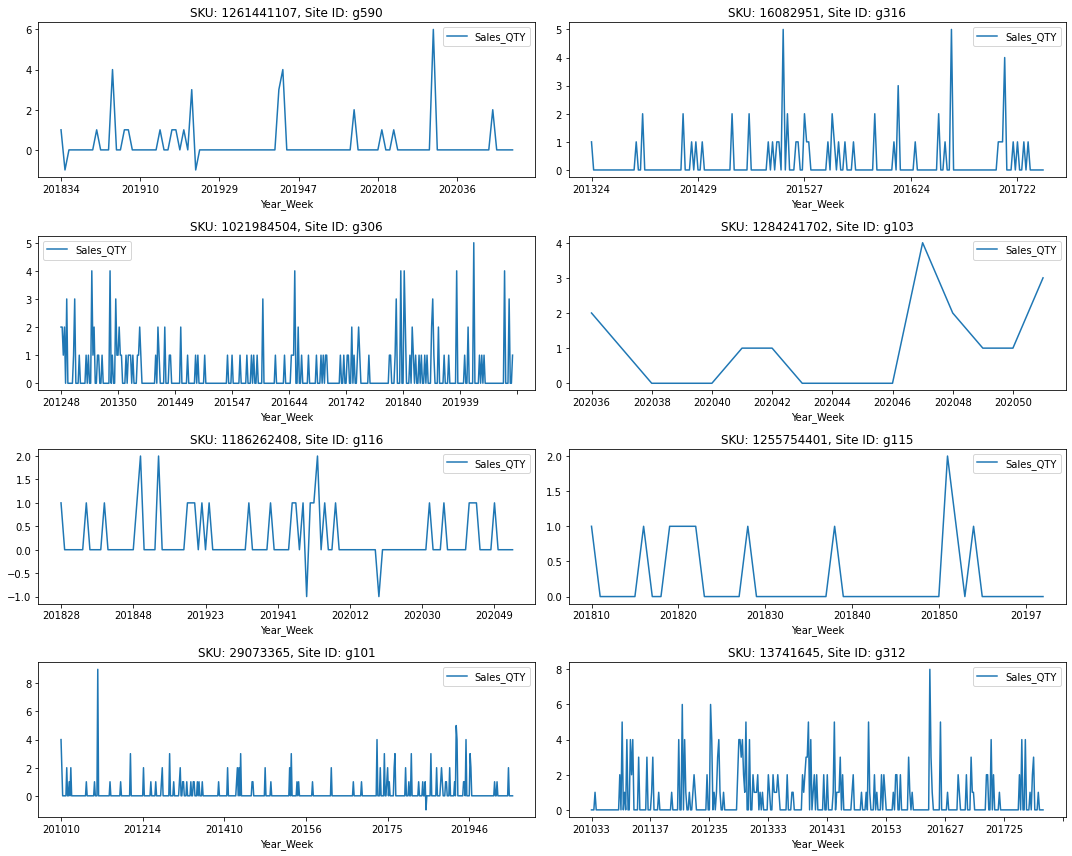

In [33]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()
